In [1]:
#!pip install tensorflow keras opencv-python-headless numpy pandas matplotlib labelImg

     ---------------------------------------- 0.0/247.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/247.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/247.7 kB 330.3 kB/s eta 0:00:01
     ------------- ----------------------- 92.2/247.7 kB 751.6 kB/s eta 0:00:01
     -------------------------------------  245.8/247.7 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 247.7/247.7 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 6.4 MB/s eta 0:00:07
   ---------------------------------------- 0.1/38.8 MB 6.4 MB/s eta 0:00:07
   ---------------------------------------- 0.2/38.8 MB 1.6 MB/s eta 0:00:25
   ---------------------------------------- 0.4/38.8 MB 2.2 MB/s eta 0:00:18
    --------------------------------------- 0.5/38.8 


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


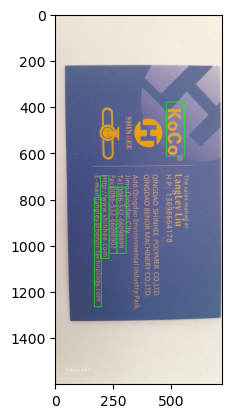

In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def load_annotations(xml_file):
    tree = ET.parse(xml_file)
    root= tree.getroot()
    boxes=[]
    for member in root.findall('object'):
        bndbox= member.find('bndbox')
        boxes.append((int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text)))

    return boxes


def load_data(image_dir, annot_dir):
    images= []
    labels = []
    for image_file in os.listdir(image_dir):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path= os.path.join(image_dir, image_file)
            annot_path= os.path.join(annot_dir, os.path.splitext(image_file)[0] + '.xml')
            if os.path.exists(annot_dir):
                image= cv2.imread(image_path) # charger l'image
                boxes= load_annotations(annot_path)
                images.append(image)
                labels.append(boxes)

    return images, labels

def display_image_with_boxes(image, boxes):
    for (xmin, ymin, xmax, ymax) in boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

image_dir='C:/Users/efiom/Desktop/Outils/Projets/AbbaTechnlogy/donnees/image_dir'
annot_dir= 'C:/Users/efiom/Desktop/Outils/Projets/AbbaTechnlogy/donnees/annot_dir'

images, labels= load_data(image_dir,  annot_dir)

#afficher les premiere images
if images and labels:
    display_image_with_boxes(images[0], labels[0])
else:
    print('Aucune image ou annotations chargée.')
                

In [16]:
#pip install tensorflow keras

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

In [24]:
#creaton du model

def create_model(input_shape):
    model= models.Sequential() # Un modèle séquentiel est une pile linéaire de couches
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) #1ere couche de convolution 2D avec un filtre de 32 d'une taille de 3X3 avec une fonction d'activation ReLu
    model.add(layers.MaxPooling2D((2,2))) #1ere couche de MaxPooling 2D avec une fenetre de 2x2
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # 2eme couche de convol2D avec 64 filtres d'une taille 3x3
    model.add(layers.MaxPooling2D((2,2))) #2eme couche de MaxPooling avec une fenetre de 2x2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))#3eme couche de convolu2D avec un filtre de 64 de taille de 3x3
    model.add(layers.Flatten()) #ajouter une couche qui va applati les cartes de caracteristiques en un vecteur 1D, CETTE ETAPE necessaire avant d'ajouter les couche denses
    model.add(layers.Dense(64, activation='relu')) #ajouter une couche dense(completement connecte) avec 64unites: pour apprendre des represenestaions complexe et produire des coordonees de la boite de delimitaion
    model.add(layers.Dense(4))# 4 output for bounding box; ces 4vunites de sortie correspondent aux coordonnees de la boite de delimitation(xmin.ymin,xmax,ymin)
    return model

input_shape=(128, 128, 3) # signifier image d'entree de taille 128x128 de 3 cannaux de couleur(RGB)
model= create_model(input_shape) #on cree notre model en faisant appel a notre fonction create_model
model.compile(optimizer='adam', loss='mean_squared_error')#Compile le modèle en spécifiant l'optimiseur et la fonction de perte.


#preparer les donnes pour l'entrainement
def preprocess_data(images, labels, target_size=(128, 128)):
    X = np.array([cv2.resize(img, target_size) for img in images])
    y = []
    for boxes in labels: # parcourt chaque ensemble de boîtes de délimitation.
        y_boxes= []
        for box in boxes:
            xmin, ymin, xmax, ymax = box # arcourt chaque boîte de délimitation.Décompose les coordonnées de la boîte de délimitation en xmin, ymin, xmax, ymax.
            y_boxes.append([xmin, ymin, xmax, ymax])
        y.append(np.mean(y_boxes, axis=0)) #Moyenne des coordonnées pour simplification; calcule la moyenne des coordonnées le long de l'axe 0 (c'est-à-dire la moyenne des xmin, ymin, xmax, ymax pour toutes les boîtes).
    y= np.array(y) #converti la liste y en un tabeau numpy
    return X, y

#creer  X et y en faisant appel a la fonction process_data
X, y = preprocess_data(images, labels)




In [27]:
#entrainement du model
model.fit(X, y, epochs=10, batch_size=8)
#sauvegarde du model
#model.save('card_model.h5')
model.save('card_model.keras') #keras recommande d'utiliser le format natif .keras au lieu de .h5 de HDF5

Epoch 1/10
3/3 [==============================] - 0s 123ms/step - loss: 10501.2188
Epoch 2/10
3/3 [==============================] - 0s 108ms/step - loss: 14469.8389
Epoch 3/10
3/3 [==============================] - 0s 108ms/step - loss: 12125.5684
Epoch 4/10
3/3 [==============================] - 0s 109ms/step - loss: 8819.3789
Epoch 5/10
3/3 [==============================] - 0s 109ms/step - loss: 9545.8730
Epoch 6/10
3/3 [==============================] - 0s 127ms/step - loss: 9327.7178
Epoch 7/10
3/3 [==============================] - 0s 146ms/step - loss: 9409.1729
Epoch 8/10
3/3 [==============================] - 0s 129ms/step - loss: 5668.9033
Epoch 9/10
3/3 [==============================] - 0s 136ms/step - loss: 7149.2710
Epoch 10/10
3/3 [==============================] - 0s 130ms/step - loss: 7081.6162


In [28]:
#EVALUATION DU MODEL

loss= model.evaluate(X, y)

print(f'Loss: {loss}')

1/1 [==============================] - 0s 385ms/step - loss: 4832.6104
Loss: 4832.6103515625


In [ ]:
def predict(image, model, target_size=(128, 128)):
    image_resized = cv2.resize(image, target_size)
    predictions = model.predict(np.expand_dims(image_resized, axis=0))
    return predictions[0]  # Retourne les prédictions pour la première (et unique) image

new_image_path = 'path/to/new/image.jpg'
new_image = cv2.imread(new_image_path)
predictions = predict(new_image, model)
print(predictions)


In [36]:
#effectuer les predictions sur les novelles images
def predict(image, model, target_size=(128, 128)):
    image_resized= cv2.resize(image, target_size)
    predictions = model.predict(np.expand_dims(image_resized, axis=0))
    return predictions[0] # retourne les predictions pour la 1ere et unique image

new_image_path='C:/Users/efiom/Desktop/Outils/Projets/AbbaTechnlogy/donnees/new_image/PHOTO-2024-07-19-12-24-06 2.jpg' #lien vers la nouvelle image
new_image= cv2.imread(new_image_path)
predictions = predict(new_image, model)
print(predictions)

1/1 [==============================] - 0s 76ms/step
[ 303.43146  659.28754  392.45596 1054.2953 ]


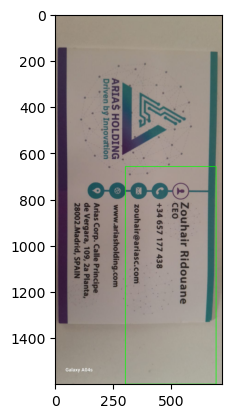

In [37]:
#affichage des predictions sur l'images

def display_predictions(image, predictions):
    xmin, ymin, xmax, ymax = predictions
    cv2.rectangle(image, (int(xmin), int(ymin), int(xmax), int(ymax)), (0, 255, 0), 2 )
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

display_predictions(new_image, predictions)